In [25]:
import numpy as np 
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score,roc_auc_score,precision_recall_curve,confusion_matrix,precision_score,confusion_matrix
from sklearn.metrics import mean_squared_error,roc_auc_score,precision_score
from sklearn.model_selection import validation_curve

In [26]:
df = pd.read_csv(r'C:\Users\Amey.R\Desktop\Kaggle Competition\Hackathon\train.csv')
df = df.set_index('Id')

In [27]:
df = df.drop_duplicates()

In [28]:
# Preprocessing Train Data
df['EduField_Dept'] = 0
for i, row in df.iterrows():
    if row['EducationField']=='Human Resources' and row['Department']=='Human Resources':
        df['EduField_Dept'][i] = 1
    elif row['EducationField']=='Life Sciences' and row['Department']=='Sales':
        df['EduField_Dept'][i] = 2
    elif row['EducationField']=='Life Sciences' and row['Department']=='Research & Development':
        df['EduField_Dept'][i] = 1
    elif row['EducationField']=='Medical' and row['Department']=='Sales':
        df['EduField_Dept'][i] = 2
    elif row['EducationField']=='Medical' and row['Department']=='Research & Development':
        df['EduField_Dept'][i] = 1
    elif row['EducationField']=='Technical Degree' and row['Department']=='Sales':
        df['EduField_Dept'][i] = 2
    elif row['EducationField']=='Technical Degree' and row['Department']=='Research & Development':
        df['EduField_Dept'][i] = 1
    elif row['EducationField']=='Marketing' and row['Department']=='Sales':
        df['EduField_Dept'][i] = 1
        
df['Edu_Age_TotalWorking'] = df['Education'] / (df['Age'] + df['TotalWorkingYears'])
df['CurrMgr_Coy'] = df['YearsWithCurrManager'] / (df['YearsAtCompany'] + 1)
df['CurrRole_CurrMgr'] = df['YearsInCurrentRole'] / (df['YearsWithCurrManager'] + 1)

# label encoding to clean up categorical data
categorical_data = {
    'BusinessTravel': {'Non-Travel':0, 'Travel_Frequently':1, 'Travel_Rarely':2}, 
    'Department': {'Human Resources':0, 'Research & Development':1, 'Sales':2}, 
    'EducationField': {'Human Resources':0, 'Life Sciences':1, 'Marketing':2, 'Medical':3, 'Technical Degree':4, 'Other':5}, 
    'Gender': {'Female':0, 'Male':0}, 
    'JobRole': {'Healthcare Representative':0, 'Human Resources':1, 'Laboratory Technician':2, 'Manager':3, 'Manufacturing Director':4, 'Research Director':5, 'Research Scientist':6, 'Sales Executive':7, 'Sales Representative':8}, 
    'MaritalStatus': {'Divorced':0, 'Single':1, 'Married':2}, 
    #'Over18': {'Y':1}, 
    'OverTime': {'No':0, 'Yes':1}    }
df = df.replace(categorical_data)

C:\Users\Amey.R\anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\Amey.R\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\Amey.R\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_

In [29]:
X = df.drop(['Attrition'], axis=1)
y = (df['Attrition'])

Top  20  Features: ['OverTime', 'MonthlyIncome', 'TotalWorkingYears', 'Age', 'YearsAtCompany', 'Edu_Age_TotalWorking', 'CurrMgr_Coy', 'StockOptionLevel', 'YearsWithCurrManager', 'JobRole', 'DistanceFromHome', 'CurrRole_CurrMgr', 'EmployeeNumber', 'YearsInCurrentRole', 'JobInvolvement', 'JobSatisfaction', 'EnvironmentSatisfaction', 'NumCompaniesWorked', 'TrainingTimesLastYear', 'Department']


(21.5, -0.5)

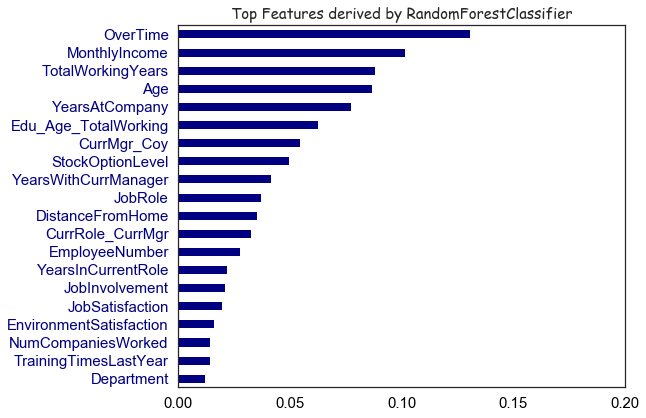

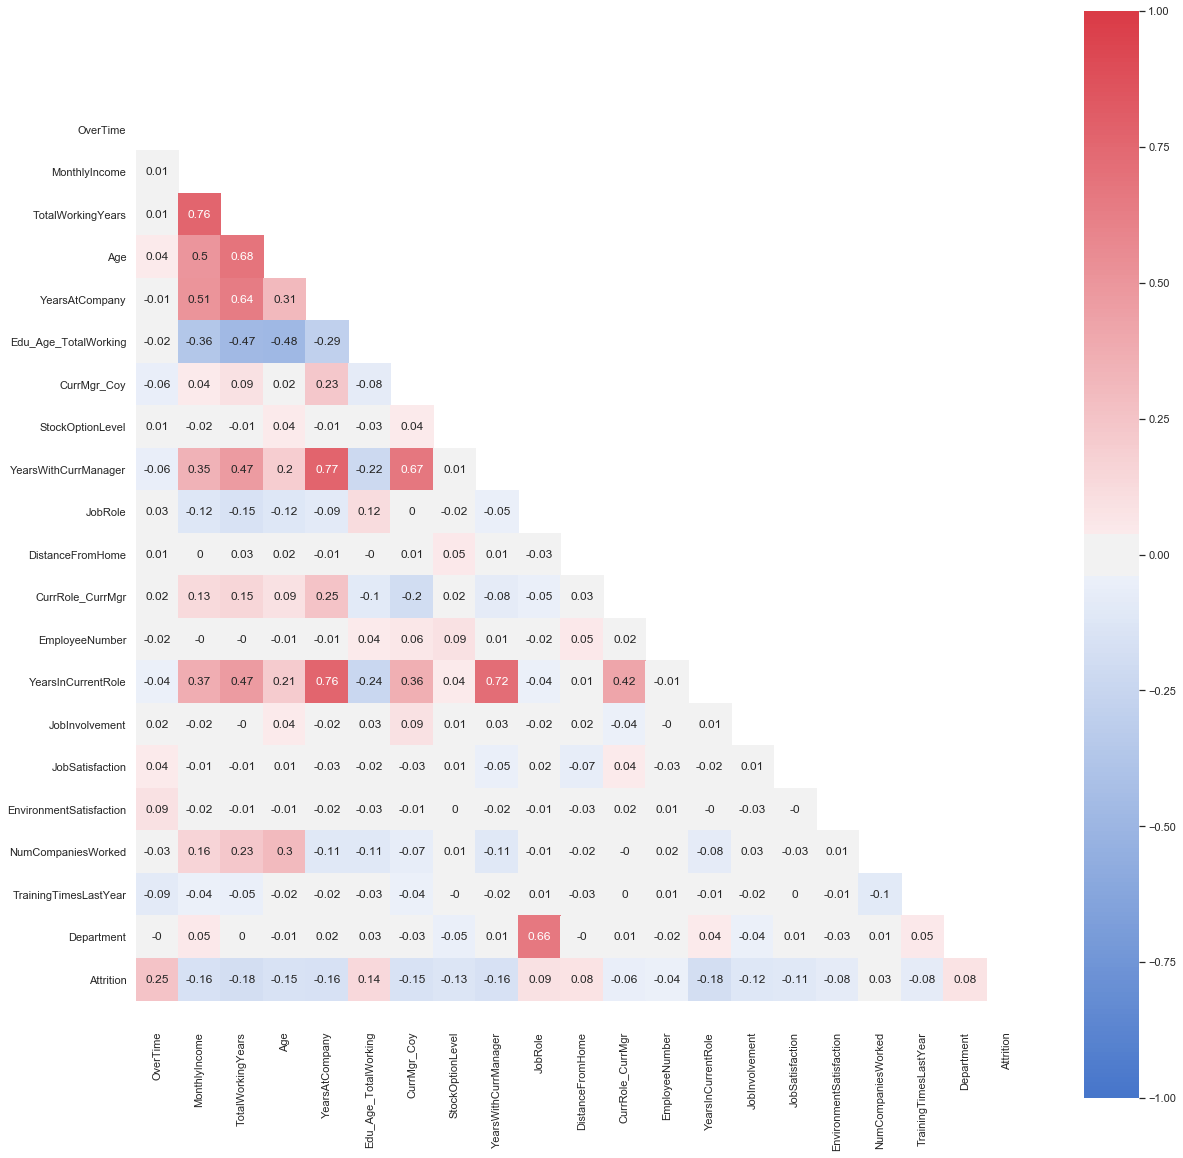

In [30]:
# use RandomForestClassifier to look for important key features
n = 20    # specify n (top n features)
rfc = RandomForestClassifier(n_estimators=200, max_depth=3)
rfc_model = rfc.fit(X, y)
pd.Series(rfc_model.feature_importances_, index=X.columns).nlargest(n).plot(kind='barh', 
    figsize=[8, n/3], color='navy').invert_yaxis()    # most important feature is on top, ie, descending order
ticks_x = np.linspace(0, 0.2, 5)   # (start, end, number of ticks)
plt.xticks(ticks_x, fontsize=15, color='black')
plt.yticks(size=15, color='navy' )
plt.title('Top Features derived by RandomForestClassifier', family='fantasy', size=15)
top10_features = pd.Series(rfc_model.feature_importances_, index=X.columns).nlargest(n)
print('Top ',n,' Features:', list(top10_features.index))

# check for correlation between top 10 features
X = df.loc[:, top10_features.index]
y = df['Attrition']
df_top10 = X.join(y)
# correlation matrix heatmap visualization
sns.set(style="white")
# Generate a mask for the upper triangle
mask = np.zeros_like(df_top10.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure to control size of heatmap
fig, ax = plt.subplots(figsize=(20,20))
# Create a custom color palette
cmap = sns.diverging_palette(255, 10, as_cmap=True)  # as_cmap returns a matplotlib colormap object rather than a list of colors
# Red=10, Green=128, Blue=255
# Plot the heatmap
sns.heatmap(df_top10.corr().round(2), mask=mask, annot=True, annot_kws={"size": 12}, square=True, 
            cmap=cmap , vmin=-1, vmax=1, ax=ax)  # annot=True display corr label
# Prevent Heatmap Cut-Off Issue
bottom, top = ax.get_ylim()
ax.set_ylim(bottom+0.5, top-0.5)

In [21]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, train_size=0.8)

In [22]:
def model(mod,model_name,x_tr,y_tr,x_tes,y_te):
    mod.fit(x_tr,y_tr)
    pred_dt=mod.predict(x_tes)
    print("-----------------------------------------------------------")
    print("     ",model_name,"      ")
    print("-----------------------------------------------------------")
    print("Accuracy ",accuracy_score(pred_dt,y_te))
    print("ROC_AUC  ",roc_auc_score(pred_dt,y_te))
    print("-----------------------------------------------------------")
    cm=confusion_matrix(pred_dt,y_te)
    print("Confusion Matrix  \n",cm)
    print("-----------------------------------------------------------")
    print("Classification Report \n",classification_report(pred_dt,y_te))
    print("-----------------------------------------------------------")
    print("MSE ",mean_squared_error(y_te,pred_dt))

In [23]:
base=np.zeros(1000)
print('Base Accuracy ',accuracy_score(base,df.Attrition))

Base Accuracy  0.843


In [34]:
rf = RandomForestClassifier(n_estimators=500,max_depth=6,random_state=1)
model(rf,'RF',X_train,y_train,X_valid,y_valid)

-----------------------------------------------------------
      RF       
-----------------------------------------------------------
Accuracy  0.83
ROC_AUC   0.831615120274914
-----------------------------------------------------------
Confusion Matrix  
 [[161  33]
 [  1   5]]
-----------------------------------------------------------
Classification Report 
               precision    recall  f1-score   support

           0       0.99      0.83      0.90       194
           1       0.13      0.83      0.23         6

    accuracy                           0.83       200
   macro avg       0.56      0.83      0.57       200
weighted avg       0.97      0.83      0.88       200

-----------------------------------------------------------
MSE  0.17


In [41]:
xg = XGBRegressor(n_estimators=1000,objective='binary:hinge',learning_rate=0.03)
model(xg,"XGB",X_train,y_train,X_valid,y_valid)

-----------------------------------------------------------
      XGB       
-----------------------------------------------------------
Accuracy  0.79
ROC_AUC   0.6230847803881512
-----------------------------------------------------------
Confusion Matrix  
 [[149  29]
 [ 13   9]]
-----------------------------------------------------------
Classification Report 
               precision    recall  f1-score   support

         0.0       0.92      0.84      0.88       178
         1.0       0.24      0.41      0.30        22

    accuracy                           0.79       200
   macro avg       0.58      0.62      0.59       200
weighted avg       0.84      0.79      0.81       200

-----------------------------------------------------------
MSE  0.21
